## 5: Applying regularization techniques to improvise the performance of VAE Model.

### L1/L2 Regularization (Weight Decay)
### Dropout
### Batch Normalization
### Beta-VAE (Modified KL Divergence Term)
### Data Augmentation

#### Pratham P (RA2211027010165)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
# Hyperparameters
latent_dim = 128
beta = 4  # For Beta-VAE
lr = 0.001
batch_size = 128
epochs = 50

In [3]:
# Data Preprocessing (Including Data Augmentation)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [4]:
# Load CIFAR-10 Dataset
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170M/170M [05:45<00:00, 494kB/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
# VAE Model with Regularization
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128*4*4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        x = self.encoder(x).view(x.shape[0], -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        x = self.fc_decode(z).view(x.shape[0], 128, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar

In [8]:
import torch
import torch.optim as optim
import torch.nn.functional as F

In [9]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# Initialize VAE model and move to device
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization (weight decay)

In [11]:
# Loss function with Beta-VAE KL Divergence
def loss_function(recon_x, x, mu, logvar, beta=4):  
    x = x.to(device)
    recon_x = recon_x.to(device)
    mu = mu.to(device)
    logvar = logvar.to(device)

    recon_loss = F.mse_loss(recon_x, x, reduction='sum')  # Reconstruction loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL Divergence

    return recon_loss + beta * kl_divergence  # Beta-VAE Regularization


In [14]:
# Training loop
epochs = 10  # Adjust as needed
vae.train()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
  )
  (fc_mu): Linear(in_features=2048, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=2048, out_features=128, bias=True)
  (fc_decode): Linear(in_features=128, out_features=2048, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [15]:
for epoch in range(epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        
        recon_x, mu, logvar = vae(data)  # Forward pass
        loss = loss_function(recon_x, data, mu, logvar)
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        train_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 314.1229
Epoch 2, Loss: 311.7625
Epoch 3, Loss: 309.9304
Epoch 4, Loss: 308.6611
Epoch 5, Loss: 307.6335
Epoch 6, Loss: 306.3864
Epoch 7, Loss: 305.7884
Epoch 8, Loss: 305.3091
Epoch 9, Loss: 304.5377
Epoch 10, Loss: 304.1542


In [17]:
# Train VAE without Regularization
vae_no_reg = VAE(latent_dim).to(device)
optimizer_no_reg = optim.Adam(vae_no_reg.parameters(), lr=lr)  # No weight decay

In [18]:

# Train VAE with Regularization
vae_reg = VAE(latent_dim).to(device)
optimizer_reg = optim.Adam(vae_reg.parameters(), lr=lr, weight_decay=1e-5)  # L2 regularization


In [19]:
def train_vae(model, optimizer, beta=4):
    model.train()
    train_losses = []
    
    for epoch in range(epochs):
        train_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            
            recon_x, mu, logvar = model(data)
            loss = loss_function(recon_x, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_loss = train_loss / len(train_loader.dataset)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

    return train_losses


In [20]:

# Train both models
losses_no_reg = train_vae(vae_no_reg, optimizer_no_reg, beta=1)  # Standard VAE (β=1)
losses_reg = train_vae(vae_reg, optimizer_reg, beta=4)  # Regularized VAE (Beta-VAE)


Epoch 1, Loss: 323.1943
Epoch 2, Loss: 225.9408
Epoch 3, Loss: 212.4193
Epoch 4, Loss: 207.4639
Epoch 5, Loss: 203.3533
Epoch 6, Loss: 200.9661
Epoch 7, Loss: 199.1312
Epoch 8, Loss: 197.9484
Epoch 9, Loss: 197.0240
Epoch 10, Loss: 195.5130
Epoch 1, Loss: 426.8143
Epoch 2, Loss: 331.1987
Epoch 3, Loss: 321.2440
Epoch 4, Loss: 316.9503
Epoch 5, Loss: 313.4660
Epoch 6, Loss: 311.8645
Epoch 7, Loss: 310.3470
Epoch 8, Loss: 309.2755
Epoch 9, Loss: 307.4729
Epoch 10, Loss: 307.0174


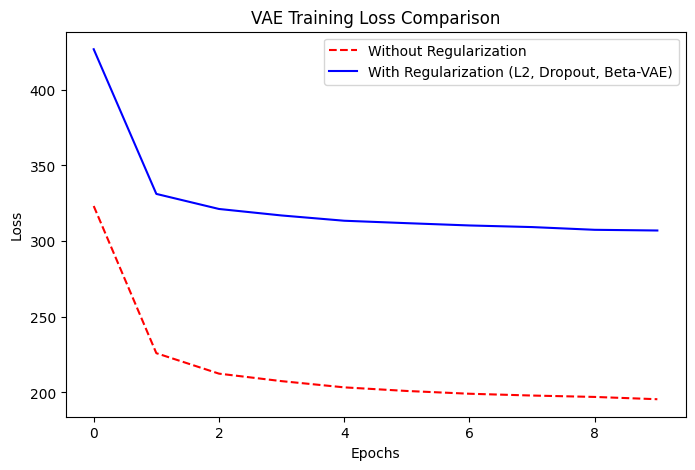

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(losses_no_reg, label="Without Regularization", linestyle="--", color="red")
plt.plot(losses_reg, label="With Regularization (L2, Dropout, Beta-VAE)", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("VAE Training Loss Comparison")
plt.legend()
plt.show()


In [22]:
import numpy as np

def visualize_reconstruction(model, test_loader, num_images=10):
    model.eval()
    with torch.no_grad():
        for batch, _ in test_loader:
            batch = batch.to(device)
            recon, _, _ = model(batch)

            fig, axes = plt.subplots(2, num_images, figsize=(12, 4))
            for i in range(num_images):
                # Original images
                axes[0, i].imshow(batch[i].permute(1, 2, 0).cpu().numpy())
                axes[0, i].axis('off')

                # Reconstructed images
                axes[1, i].imshow(recon[i].permute(1, 2, 0).cpu().numpy())
                axes[1, i].axis('off')

            axes[0, 0].set_title("Original Images")
            axes[1, 0].set_title("Reconstructed Images")
            plt.show()
            break  # Show only 1 batch


VAE without Regularization:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7499182..0.6392807].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9351315..0.9464759].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.86793655..0.96880484].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.83529

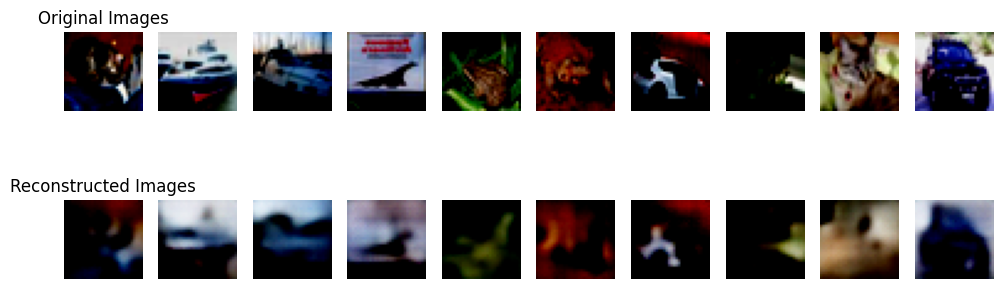

In [23]:
# Compare Reconstructions
print("VAE without Regularization:")
visualize_reconstruction(vae_no_reg, test_loader)

VAE with Regularization:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8980392..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.45606384..0.3989796].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8386533..0.9470027].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8030763..0.9543005].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..0.835294

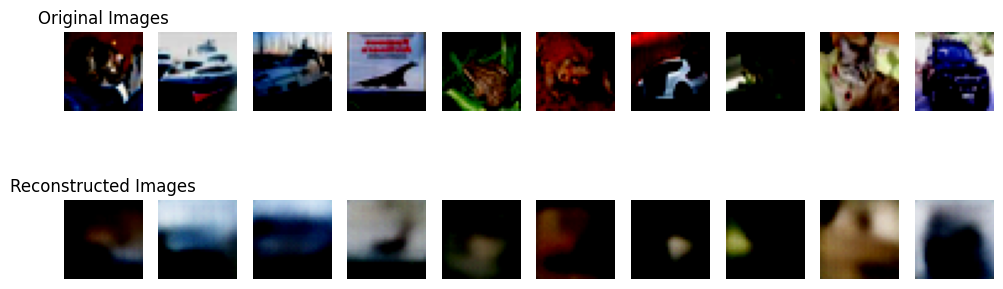

In [24]:
print("VAE with Regularization:")
visualize_reconstruction(vae_reg, test_loader)
